## Debugging the `LabelModel` with deps + higher-order cliques

In [1]:
%matplotlib inline
import sys
sys.path.append("../") # go to parent dir

import numpy as np
import torch
import matplotlib.pyplot as plt
import mpmath

from synthetic.generate import SingleTaskTreeDepsGenerator
from metal.label_model import LabelModel, CliqueTree
from metal.label_model.utils import (
    compute_mu,
    compute_covariance,
    compute_inv_covariance,
    print_matrix,
    visualize_matrix
)

/lfs/1/annhe/anaconda3/envs/metal/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


### Generating a dataset

In [2]:
# Generate synthetic dataset
np.random.seed(2)
N = 10000
M = 10
K = 1
EDGE_PROB=1.0
data = SingleTaskTreeDepsGenerator(N, M, k=K, edge_prob=EDGE_PROB)



(0, 1)   [0.49239541]
(1, 1)   [0.12333361]
(2, 1)   [0.59469623]
(3, 1)   [0.49179015]
(4, 1)   [0.47833102]
(5, 1)   [0.39730134]
(6, 1)   [0.28418377]
(7, 1)   [0.65734387]
(8, 1)   [0.36968921]
(9, 1)   [0.34014455]
((0, 1), 1, 1)   [0.65902045]
((1, 2), 1, 1)   [0.57622788]
((2, 3), 1, 1)   [0.22112195]
((3, 4), 1, 1)   [0.56222031]
((4, 5), 1, 1)   [0.26599588]
((5, 6), 1, 1)   [0.80680163]
((6, 7), 1, 1)   [0.86857776]
((7, 8), 1, 1)   [0.54481315]
((8, 9), 1, 1)   [0.86190534]
Labeler =  0
P(L= 0 , Y= 1 ) =  0.277484719543213
P(L= 1 , Y= 1 ) =  0.722515280456787
Labeler =  1
P(L= 0 , Y= 1 ) =  0.2678250016430602
P(L= 1 , Y= 1 ) =  0.7321749983569398
Labeler =  2
P(L= 0 , Y= 1 ) =  0.23832420112429975
P(L= 1 , Y= 1 ) =  0.7616757988757002
Labeler =  3
P(L= 0 , Y= 1 ) =  0.2564948790056145
P(L= 1 , Y= 1 ) =  0.7435051209943855
Labeler =  4
P(L= 0 , Y= 1 ) =  0.2525536111911135
P(L= 1 , Y= 1 ) =  0.7474463888088865
Labeler =  5
P(L= 0 , Y= 1 ) =  0.22492920043060005
P(L= 1 , Y= 1 

P(L_ 4 = 0 , L_ 6 = 0  | Y =  1 ) =  0.04427706018601464
P(L_ 4 = 0 , L_ 6 = 1  | Y =  1 ) =  0.20827655100509887
P(L_ 4 = 1 , L_ 6 = 0  | Y =  1 ) =  0.12643872235800485
P(L_ 4 = 1 , L_ 6 = 1  | Y =  1 ) =  0.6210076664508817
Labelers =  (4, 7)
P(L_ 4 = 0 , L_ 7 = 0  | Y =  1 ) =  0.03725363964606395
P(L_ 4 = 0 , L_ 7 = 1  | Y =  1 ) =  0.2152999715450496
P(L_ 4 = 1 , L_ 7 = 0  | Y =  1 ) =  0.10966086792112419
P(L_ 4 = 1 , L_ 7 = 1  | Y =  1 ) =  0.6377855208877624
Labelers =  (4, 8)
P(L_ 4 = 0 , L_ 8 = 0  | Y =  1 ) =  0.049557708099677765
P(L_ 4 = 0 , L_ 8 = 1  | Y =  1 ) =  0.20299590309143573
P(L_ 4 = 1 , L_ 8 = 0  | Y =  1 ) =  0.14661221812602573
P(L_ 4 = 1 , L_ 8 = 1  | Y =  1 ) =  0.6008341706828607
Labelers =  (4, 9)
P(L_ 4 = 0 , L_ 9 = 0  | Y =  1 ) =  0.0675193608873296
P(L_ 4 = 0 , L_ 9 = 1  | Y =  1 ) =  0.18503425030378398
P(L_ 4 = 1 , L_ 9 = 0  | Y =  1 ) =  0.19981684025296745
P(L_ 4 = 1 , L_ 9 = 1  | Y =  1 ) =  0.5476295485559193
Labelers =  (5, 6)
P(L_ 5 = 0 , L_ 6

../synthetic/generate.py:610: RuntimeWarning: divide by zero encountered in true_divide
  p = np.ones(self.k+1) * (1 - prob_y - prob_0) / (self.k - 1)
../synthetic/generate.py:610: RuntimeWarning: invalid value encountered in true_divide
  p = np.ones(self.k+1) * (1 - prob_y - prob_0) / (self.k - 1)


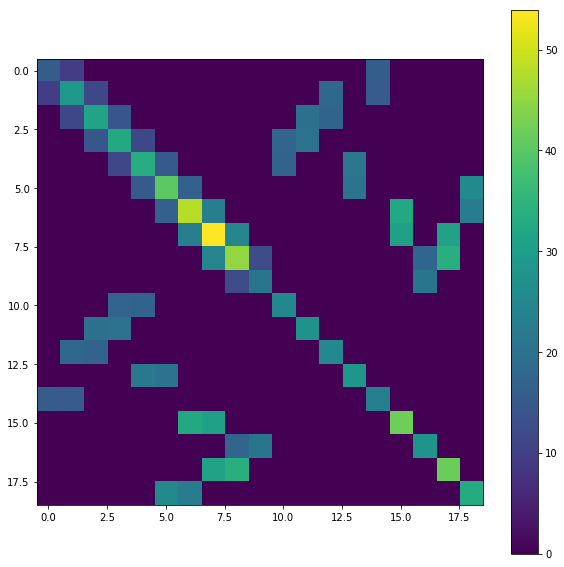

In [3]:
# mask the diagonals so we don't get influenced by them unfairly
sg_no_diag = np.copy(data.sig_inv)
# for i in range(M):
#     sg_no_diag[i*2:i*2+2,i*2:i*2+2] = np.zeros([2,2])
# for j in range(M-1):
#     sg_no_diag[2*M+j*4:2*M+j*4+4,2*M+j*4:2*M+j*4+4] = np.zeros([4,4])

# print(data.E)
visualize_matrix(np.abs(sg_no_diag))

In [4]:
ctree = CliqueTree(M,K,data.E,False)
print(ctree.c_data)

OrderedDict([((0,), {'start_index': 0, 'end_index': 1, 'max_cliques': {5}, 'size': 1, 'members': {0}}), ((1,), {'start_index': 1, 'end_index': 2, 'max_cliques': {2, 5}, 'size': 1, 'members': {1}}), ((2,), {'start_index': 2, 'end_index': 3, 'max_cliques': {1, 2}, 'size': 1, 'members': {2}}), ((3,), {'start_index': 3, 'end_index': 4, 'max_cliques': {0, 1}, 'size': 1, 'members': {3}}), ((4,), {'start_index': 4, 'end_index': 5, 'max_cliques': {0, 3}, 'size': 1, 'members': {4}}), ((5,), {'start_index': 5, 'end_index': 6, 'max_cliques': {8, 3}, 'size': 1, 'members': {5}}), ((6,), {'start_index': 6, 'end_index': 7, 'max_cliques': {8, 4}, 'size': 1, 'members': {6}}), ((7,), {'start_index': 7, 'end_index': 8, 'max_cliques': {4, 7}, 'size': 1, 'members': {7}}), ((8,), {'start_index': 8, 'end_index': 9, 'max_cliques': {6, 7}, 'size': 1, 'members': {8}}), ((9,), {'start_index': 9, 'end_index': 10, 'max_cliques': {6}, 'size': 1, 'members': {9}})])


### Training the `LabelModel`

Note that:
* The `train` method assembles other data structures, such as the dependencies junction tree, etc.
* The `higher_order_cliques` kwarg controls whether or not to include them

In [5]:
lm = LabelModel(k=data.k, class_balance=data.p)

In [6]:
lm.config['higher_order_cliques'] = False

In [7]:
'''# Generate the "correct" mu
lm._set_constants(data.L)
lm._set_dependencies(data.E)
mu = compute_mu(lm._get_augmented_label_matrix(data.L.todense()), data.Y, K, data.p)

# Compute O, O_inv, P based on L
lm._generate_O(data.L.todense())
O = lm.O.numpy()
print(O)
d, d = O.shape
O_inv = np.linalg.inv(O)
P = np.diag(data.p)

JJT = np.linalg.inv(np.linalg.inv(P) - mu.T @ O_inv @ mu)
ZZT = O_inv @ mu @ JJT @ mu.T @ O_inv.T'''
print('temporarily commented out')

temporarily commented out


In [8]:
# Check that JJT is indeed PSD ==> ZZT is rank k
#np.linalg.eig(JJT)[0]

In [9]:
#np.linalg.eig((ZZT + ZZT.T)/2)[0]

In [10]:
lm.train(
    data.L,
    deps=data.E,
    all_unary_cliques=True,
    higher_order_cliques=False,
    n_epochs=50000,
    print_every=5000,
    lr=0.0001,
    l2=0,
    O_inv_prec=1024,
    #O_inv=ZZT
)

lm._set_constants(data.L)
lm._set_dependencies(data.E)
mu = compute_mu(lm._get_augmented_label_matrix(data.L.todense()), data.Y, K, data.p)


# Test against the true parameter values
mu_est = lm.mu.detach().numpy()
print(f"Average absolute error: {np.mean(np.abs(mu_est - mu))}")

Computing O^{-1}...


ZeroDivisionError: matrix is numerically singular

### Sanity check that the true $Z$ gets lower loss

In [ ]:
sorted(np.linalg.eig(O)[0])[::-1]

In [ ]:
O = lm.O.numpy()
d, d = O.shape
O_inv = lm.O_inv.numpy()
mask = lm.mask.numpy()
P = lm.P.numpy()

JJT = np.linalg.inv(np.linalg.inv(P) - mu.T @ O_inv @ mu)
ZZT = O_inv @ mu @ JJT @ mu.T @ O_inv.T

np.linalg.norm((O_inv + ZZT) * mask)**2

#### Seed=2

In [ ]:
visualize_matrix(mask)

In [ ]:
#visualize_matrix(np.abs((O_inv + ZZT) * mask))

In [ ]:
lm.c_data

In [ ]:
Z_est = lm.Z.detach().numpy()
visualize_matrix(np.abs((O_inv + Z_est @ Z_est.T) * mask))

#### Seed=1

In [ ]:
visualize_matrix(mask)

In [ ]:
visualize_matrix(np.abs((O_inv + ZZT) * mask))

In [ ]:
Z_est = lm.Z.detach().numpy()
visualize_matrix(np.abs((O_inv + Z_est @ Z_est.T) * mask))

#### Seed=0

In [ ]:
visualize_matrix(mask)

In [ ]:
visualize_matrix(np.abs((O_inv + ZZT) * mask))

In [ ]:
Z_est = lm.Z.detach().numpy()
visualize_matrix(np.abs((O_inv + Z_est @ Z_est.T) * mask))

### Visualizing matrices

In [ ]:
visualize_matrix(np.abs(mu_est - mu))

In [ ]:
visualize_matrix(np.abs(mu_est - mu))

In [ ]:
lm.c_data

In [ ]:
data.E

### Trying to solve with `scipy.optimize.minimize`

In [ ]:
from scipy.optimize import minimize

O_inv = lm.O_inv.numpy()
mask = lm.mask.numpy()

z0 = np.random.randn(lm.d * lm.k)
l import LabelModl import LabelModel
from metal.label_model.utils import (
    compute_mu,
    compute_covariance,
    compute_inv_covariance,
    print_matrix,el
from metal.label_model.utils import (
    compute_mu,
    compute_covariance,
    compute_inv_covariance,
    print_matrix,
def objective_fn(z):
    Z = z.reshape(-1, data.k)
    return np.linalg.norm( (O_inv + Z @ Z.T) * mask )**2

def gradient_fn(z):
    Z = z.reshape(-1, data.k)
    X = (O_inv + Z @ Z.T) * mask
    return np.ravel(X @ Z)

res = minimize(objective_fn, z0, jac=gradient_fn, method='BFGS')
Z = res['x'].reshape(-1, data.k)
res['fun']

In [ ]:
O = lm.O.numpy()
P = lm.P.numpy()
I_k = np.eye(data.k)
Q = O @ Z @ np.linalg.inv(I_k + Z.T @ O @ Z) @ Z.T @ O

mu0 = np.random.randn(lm.d * lm.k)

def objective_fn_2(mu):
    M = mu.reshape(-1, data.k)
    return np.linalg.norm(Q - M @ P @ M.T)**2 + np.linalg.norm(np.sum(M @ P, 1) - np.diag(O))**2

res_2 = minimize(objective_fn_2, mu0, method='BFGS')
M = res_2['x'].reshape(-1, data.k)
res_2['fun']

In [ ]:
# Test against the true parameter values
print(f"Average absolute error: {np.mean(np.abs(M - mu))}")

## Visualizing the inverse covariance matrix

In [ ]:
J = compute_inv_covariance(
    lm._get_augmented_label_matrix(data.L.todense()),
    data.Y,
    data.k,
    data.p
)
visualize_matrix(np.abs(J))

In [ ]:
visualize_matrix(lm.mask.numpy(), fig_size=[5,5])

In [ ]:
O_inv = lm.O_inv.numpy()
Z = lm.Z.detach().numpy()
mask = lm.mask.numpy()
visualize_matrix(np.abs((O_inv + Z@Z.T) * mask))

### Looking at the internal 'bookkeeping' of cliques...

In [ ]:
lm.c_data

In [ ]:
# Dependency edge weights
[((i,j), data.theta[(i,j)]) for i,j in data.E]